In [1]:
# Imports and GPU check
import time

import matplotlib.pyplot as plt
import numpy as np
import torchaudio
from torch import nn
import torchvision
import torchvision.transforms as transforms
from torch import nn, optim

import os
import pandas as pd
import librosa
import torch
from torch.utils.data import Dataset, DataLoader


# Check for GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [2]:
# Hyperparameters
dataset_size = 5000  # Reduced dataset size for quicker training

epochs = 50
learning_rate = 0.001

METADATA_FILE = 'Pytorch/Data/musicnet_metadata.csv'
AUDIO_DIR = 'Pytorch/Data/musicnet/musicnet/train_data'
ANNOTATIONS_FILE = 'Pytorch/Data/musicnet/musicnet/train_labels'
sample_rate = 44100
num_samples = 22050

We are creating a function to handle Dataloader

In [3]:
def create_data_loader(train_data, batch_size):
    train_dataloader = DataLoader(train_data, batch_size=batch_size)
    return train_dataloader

We can use a single function to train our model but we won't. This is placeholder code.

In [4]:
def train_single_epoch(model, data_loader, loss_fn, optimizer, device):
    for input ,target in data_loader:
        input, target = input.to(device), target.to(device)
        # loss
        prediction = model(input)
        loss = loss_fn(prediction, target)
        # backpropogation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f"Loss: {loss.item()}")

We train our model here

In [5]:
def train(model, data_loader, loss_fn, optimizer, epochs, device):
    for i in range(epochs):
        for input ,target in data_loader:
            input, target = input.to(device), target.to(device)
            # loss
            prediction = model(input)
            loss = loss_fn(prediction, target)
            # backpropogation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        print("-----------------------------------------------")
        print(f"Loss: {loss.item()}")
    print("Training completed!!")

We plot our metrics with this function below.

In [6]:
def plot_metrics(train_losses, train_accuracies, validation_losses, validation_accuracies):
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(validation_losses, label='Validation Loss')
    plt.title('Training vs. Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(validation_accuracies, label='Validation Accuracy')
    plt.title('Training vs. Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()

We want to train our data first. So we import all csv files that are in train_label directory. We create a pandas dataframe and we concatenate all the csv files into one dataframe.

In [7]:
project_dir = os.getcwd()
labels_dir = os.path.join(project_dir, 'Data', 'musicnet', 'musicnet', 'train_labels')
dfs = []

for file in os.listdir(labels_dir):
    label_path = os.path.join(labels_dir, file)
    df = pd.read_csv(label_path, index_col=None, header=0)
    df['ID'] = int(file.split('.')[0])  # Extract ID from file name and add as a new column
    dfs.append(df)

train_dataframe = pd.concat(dfs, axis=0, ignore_index=True)


Below we do some exploratory data analysis on the dataframe

In [8]:
train_dataframe.head()

,start_time,end_time,instrument,note,start_beat,end_beat,note_value,ID
0,9182,90078,43,53,4.0,1.5,Dotted Quarter,1727
1,9182,33758,42,65,4.0,0.5,Eighth,1727
2,9182,62430,1,69,4.0,1.0,Quarter,1727
3,9182,202206,44,41,4.0,3.5,Whole,1727
4,9182,62430,1,81,4.0,1.0,Quarter,1727


In [9]:
train_dataframe.instrument.unique()

array([43, 42,  1, 44, 41, 72, 71, 61, 74, 69,  7], dtype=int64)

In [10]:
train_dataframe.shape

(1075951, 8)

In [11]:
train_dataframe.ID.unique()

array([1727, 1728, 1729, 1730, 1733, 1734, 1735, 1739, 1742, 1749, 1750,
       1751, 1752, 1755, 1756, 1757, 1758, 1760, 1763, 1764, 1765, 1766,
       1768, 1771, 1772, 1773, 1775, 1776, 1777, 1788, 1789, 1790, 1791,
       1792, 1793, 1805, 1807, 1811, 1812, 1813, 1817, 1818, 1822, 1824,
       1828, 1829, 1835, 1859, 1872, 1873, 1876, 1893, 1916, 1918, 1919,
       1922, 1923, 1931, 1932, 1933, 2075, 2076, 2077, 2078, 2079, 2080,
       2081, 2082, 2083, 2104, 2105, 2112, 2113, 2114, 2116, 2117, 2118,
       2119, 2127, 2131, 2138, 2140, 2147, 2148, 2149, 2150, 2151, 2154,
       2155, 2156, 2157, 2158, 2159, 2160, 2161, 2166, 2167, 2168, 2169,
       2177, 2178, 2179, 2180, 2186, 2194, 2195, 2196, 2198, 2200, 2201,
       2202, 2203, 2204, 2207, 2208, 2209, 2210, 2211, 2212, 2213, 2214,
       2215, 2217, 2218, 2219, 2220, 2221, 2222, 2224, 2225, 2227, 2228,
       2229, 2230, 2231, 2232, 2234, 2237, 2238, 2239, 2240, 2241, 2242,
       2243, 2244, 2247, 2248, 2282, 2283, 2284, 22

We do the same for the test data as we will need them later.

In [12]:
project_dir = os.getcwd()
labels_dir = os.path.join(project_dir, 'Data', 'musicnet', 'musicnet', 'test_labels')
dfs = []

for file in os.listdir(labels_dir):
    label_path = os.path.join(labels_dir, file)
    df = pd.read_csv(label_path, index_col=None, header=0)
    df['ID'] = int(file.split('.')[0])  # Extract ID from file name and add as a new column
    dfs.append(df)

test_dataframe = pd.concat(dfs, axis=0, ignore_index=True)
test_dataframe.head()

,start_time,end_time,instrument,note,start_beat,end_beat,note_value,ID
0,90078,124382,1,63,0.0,1.000,Quarter,1759
1,90078,124382,1,75,0.0,1.000,Quarter,1759
2,90078,110558,1,48,0.0,0.375,Dotted Sixteenth,1759
3,114654,122334,1,55,0.5,0.375,Dotted Sixteenth,1759
4,124382,139742,1,65,1.0,1.000,Quarter,1759


We do some exploratory data analysis on the test dataframe

In [13]:
test_dataframe.instrument.unique()


array([ 1, 72, 71, 61, 41, 42, 43], dtype=int64)

In [20]:
train_dataframe.instrument.unique()

array([43, 42,  1, 44, 41, 72, 71, 61, 74, 69,  7], dtype=int64)

We will now create a dataset class to handle our data. We will use the torchaudio library to create a mel spectrogram of our audio data.

In [21]:
from Pytorch.Dataset.MusicDataset import MusicDataset
from Pytorch.Model.CNN import CNNNetwork
# Example usage:
 # instantiate dataset
 
mel_spectrogram = torchaudio.transforms.MelSpectrogram(
 sample_rate=sample_rate,
n_fft=1024,
hop_length=512,
n_mels=64
)

project_dir = os.getcwd()
train_data_dir = os.path.join(project_dir, 'Data', 'musicnet', 'musicnet', 'train_data')
metadata_file = os.path.join(project_dir, 'Data', 'musicnet_metadata.csv')
#labels_dir = os.path.join(project_dir, 'Data', 'musicnet', 'musicnet', 'train_labels')
max_train_data_size = 1 * 1024 * 1024 * 1024  # 1GB in bytes

train_dataset = MusicDataset(train_data_dir,train_dataframe,mel_spectrogram,
                 sample_rate, num_samples, device, max_size_bytes=max_train_data_size)

# Create a DataLoader
batch_size = 32
#train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

train_dataloader = create_data_loader(train_dataset, batch_size)

cnn = CNNNetwork().to(device)
print(cnn)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn.parameters(), lr=learning_rate)




CNNNetwork(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear): Linear(in_features=2560, out_features=11, bias=True)
  (softmax): Softmax(dim=1)
)


We will map our instruments using this dictionary from Kaggle. https://www.kaggle.com/datasets/imsparsh/musicnet-dataset/discussion/303526

In [16]:
instruments_map = {
1: "Acoustic Grand Piano",
2: "Bright Acoustic Piano",
3: "Electric Grand Piano",
4: "Honky-tonk Piano",
5: "Electric Piano 1",
6: "Electric Piano 2",
7: "Harpsichord",
8: "Clavi",
9: "Celesta",
10: "Glockenspiel",
11: "Music Box",
12: "Vibraphone",
13: "Marimba",
14: "Xylophone",
15: "Tubular Bells",
16: "Dulcimer",
17: "Drawbar Organ",
18: "Percussive Organ",
19: "Rock Organ",
20: "Church Organ",
21: "Reed Organ",
22: "Accordion",
23: "Harmonica",
24: "Tango Accordion",
25: "Acoustic Guitar (nylon)",
26: "Acoustic Guitar (steel)",
27: "Electric Guitar (jazz)",
28: "Electric Guitar (clean)",
29: "Electric Guitar (muted)",
30: "Overdriven Guitar",
31: "Distortion Guitar",
32: "Guitar harmonics",
33: "Acoustic Bass",
34: "Electric Bass (finger)",
35: "Electric Bass (pick)",
36: "Fretless Bass",
37: "Slap Bass 1",
38: "Slap Bass 2",
39: "Synth Bass 1",
40: "Synth Bass 2",
41: "Violin",
42: "Viola",
43: "Cello",
44: "Contrabass",
45: "Tremolo Strings",
46: "Pizzicato Strings",
47: "Orchestral Harp",
48: "Timpani",
49: "String Ensemble 1",
50: "String Ensemble 2",
51: "SynthStrings 1",
52: "SynthStrings 2",
53: "Choir Aahs",
54: "Voice Oohs",
55: "Synth Voice",
56: "Orchestra Hit",
57: "Trumpet",
58: "Trombone",
59: "Tuba",
60: "Muted Trumpet",
61: "French Horn",
62: "Brass Section",
63: "SynthBrass 1",
64: "SynthBrass 2",
65: "Soprano Sax",
66: "Alto Sax",
67: "Tenor Sax",
68: "Baritone Sax",
69: "Oboe",
70: "English Horn",
71: "Bassoon",
72: "Clarinet",
73: "Piccolo",
74: "Flute",
75: "Recorder",
76: "Pan Flute",
77: "Blown Bottle",
78: "Shakuhachi",
79: "Whistle",
80: "Ocarina",
81: "Lead 1 (square)",
82: "Lead 2 (sawtooth)",
83: "Lead 3 (calliope)",
84: "Lead 4 (chiff)",
85: "Lead 5 (charang)",
86: "Lead 6 (voice)",
87: "Lead 7 (fifths)",
88: "Lead 8 (bass + lead)",
89: "Pad 1 (new age)",
90: "Pad 2 (warm)",
91: "Pad 3 (polysynth)",
92: "Pad 4 (choir)",
93: "Pad 5 (bowed)",
94: "Pad 6 (metallic)",
95: "Pad 7 (halo)",
96: "Pad 8 (sweep)",
97: "FX 1 (rain)",
98: "FX 2 (soundtrack)",
99: "FX 3 (crystal)",
100: "FX 4 (atmosphere)",
101: "FX 5 (brightness)",
102: "FX 6 (goblins)",
103: "FX 7 (echoes)",
104: "FX 8 (sci-fi)",
105: "Sitar",
106: "Banjo",
107: "Shamisen",
108: "Koto",
109: "Kalimba",
110: "Bag pipe",
111: "Fiddle",
112: "Shanai",
113: "Tinkle Bell",
114: "Agogo",
115: "Steel Drums",
116: "Woodblock",
117: "Taiko Drum",
118: "Melodic Tom",
119: "Synth Drum",
120: "Reverse Cymbal",
121: "Guitar Fret Noise",
122: "Breath Noise",
123: "Seashore",
124: "Bird Tweet",
125: "Telephone Ring",
126: "Helicopter",
127: "Applause",
128: "Gunshot"
}
instruments_np = train_dataframe.instrument.unique()
instruments_list =instruments_np.tolist()
for keys,values in instruments_map.items():
    print(keys)
    #instruments_list.append(values)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128


We will demonstrate the attributes of our instruments list

In [17]:
type(instruments_list)

list

In [18]:
len(instruments_list)

11

In [22]:
instruments_list

[43, 42, 1, 44, 41, 72, 71, 61, 74, 69, 7]

We will now train our model

In [19]:
 # train
train(cnn, train_dataloader,loss_fn, optimizer, epochs,device)

IndexError: Target 43 is out of bounds.

We will now save our model

In [ ]:
# save model
torch.save(cnn.state_dict(), "saved_model/soundclassifier.pth")
print("Trained model saved at soundclassifier.pth") 

We create a function that makes predictions based on the mapping of instruments

In [53]:
def predict(model, input, target, class_mapping):
    model.eval()
    with torch.no_grad():
        predictions = model(input)
        # Tensor (1, 128) -> [ [0.1, 0.01, ..., 0.6] ]
        predicted_index = predictions[0].argmax(0)
        predicted = class_mapping[predicted_index]
        expected = class_mapping[target]
    return predicted, expected


We will now load our model and make an inference

In [54]:

state_dict = torch.load("saved_model/soundclassifier.pth")
cnn.load_state_dict(state_dict)

mel_spectrogram = torchaudio.transforms.MelSpectrogram(
        sample_rate=sample_rate,
        n_fft=1024,
        hop_length=512,
        n_mels=64
    )

project_dir = os.getcwd()
test_data_dir = os.path.join(project_dir, 'Data', 'musicnet', 'musicnet', 'test_data')
max_test_data_size = 1 * 1024 * 1024 * 1024  # 1GB in bytes

test_dataset = MusicDataset(test_data_dir,test_dataframe,mel_spectrogram,
                 sample_rate, num_samples, device, max_size_bytes=max_test_data_size)

test_dataloader = create_data_loader(test_dataset, batch_size)
# get a sample from the us dataset for inference
input, target = test_dataset[1][0], test_dataset[1][1] # [num_cha, fr, t]
input.unsqueeze_(0)
# make an inference
predicted, expected = predict(cnn, input, target,
                              instruments_list)
print(f"Predicted: '{predicted}', expected: '{expected}'")


RuntimeError: Error(s) in loading state_dict for CNNNetwork:
	size mismatch for linear.weight: copying a param with shape torch.Size([128, 2560]) from checkpoint, the shape in current model is torch.Size([11, 2560]).
	size mismatch for linear.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([11]).

We will now create a function to train and validate our model


In [23]:
def train_and_validate(model, train_loader, test_loader, criterion, optimizer, epochs, device):
    train_losses = []
    train_accuracies = []
    validation_losses = []
    validation_accuracies = []
    
    start_time = time.time()
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_loss, correct_train, total_train = 0, 0, 0
        for audio, labels in train_loader:
            audio, labels = audio.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(audio)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * audio.size(0)
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
        
        train_loss /= len(train_loader.dataset)
        train_accuracy = 100 * correct_train / total_train
        
        # Validation Phase
        model.eval()
        validation_loss, correct_val, total_val = 0, 0, 0
        with torch.no_grad():
            for audio, labels in test_loader:
                audio, labels = audio.to(device), labels.to(device)
                outputs = model(audio)
                loss = criterion(outputs, labels)
                
                validation_loss += loss.item() * audio.size(0)
                _, predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()
        
        validation_loss /= len(test_loader.dataset)
        validation_accuracy = 100 * correct_val / total_val
        
        # Store metrics
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        validation_losses.append(validation_loss)
        validation_accuracies.append(validation_accuracy)
        
        print(f'Epoch [{epoch+1}/{epochs}], Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%, Validation Loss: {validation_loss:.4f}, Validation Accuracy: {validation_accuracy:.2f}%')
    
    end_time = time.time()
    execution_time = end_time - start_time
    minutes = int(execution_time // 60)
    seconds = int(execution_time % 60)
    print(f"\nExecution time: {minutes:02}:{seconds:02}")
    
    return train_losses, train_accuracies, validation_losses, validation_accuracies

In [36]:
train_losses, train_accuracies, validation_losses, validation_accuracies = train_and_validate(cnn, train_dataloader, test_dataloader, loss_fn, optimizer, epochs, device)

Epoch [1/50], Training Loss: 4.7258, Training Accuracy: 13.95%, Validation Loss: 4.7651, Validation Accuracy: 10.00%
Epoch [2/50], Training Loss: 4.7258, Training Accuracy: 13.95%, Validation Loss: 4.7651, Validation Accuracy: 10.00%
Epoch [3/50], Training Loss: 4.7258, Training Accuracy: 13.95%, Validation Loss: 4.7651, Validation Accuracy: 10.00%
Epoch [4/50], Training Loss: 4.7258, Training Accuracy: 13.95%, Validation Loss: 4.7651, Validation Accuracy: 10.00%
Epoch [5/50], Training Loss: 4.7258, Training Accuracy: 13.95%, Validation Loss: 4.7651, Validation Accuracy: 10.00%
Epoch [6/50], Training Loss: 4.7258, Training Accuracy: 13.95%, Validation Loss: 4.7651, Validation Accuracy: 10.00%
Epoch [7/50], Training Loss: 4.7258, Training Accuracy: 13.95%, Validation Loss: 4.7651, Validation Accuracy: 10.00%
Epoch [8/50], Training Loss: 4.7258, Training Accuracy: 13.95%, Validation Loss: 4.7651, Validation Accuracy: 10.00%
Epoch [9/50], Training Loss: 4.7258, Training Accuracy: 13.95%, 

# We will now plot our metrics

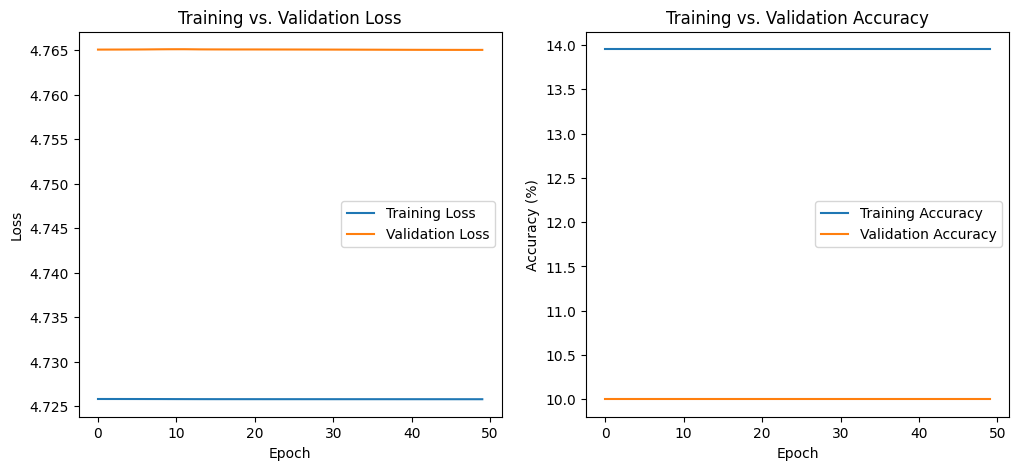

In [37]:
plot_metrics(train_losses, train_accuracies, validation_losses, validation_accuracies)